In [27]:
import random
import sys
import numpy as np
import csv
import math
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt

# progress statement at end of pdf

In [2]:
class game():
    def __init__(self, suits = 4):
        self.agentHand = defaultdict(int)
        self.compHand = defaultdict(int)
        self.book = defaultdict(int)
        self.count = 0
        for i in range(1,14):
            self.agentHand[i] = 0
            self.compHand[i] = 0
            self.book[i] = 0
        self.suits = suits
        self.deck = list(range(1,14)) * self.suits # cards as 1-13, a=1, j=11, etc
        random.shuffle(self.deck)
        self.score = [0,0] #agent score, computer score
        self.stepCount = 0 # debug
        self.deal()
        #self.debug()
        return
        
    def emptyDeck(self):
        return len(self.deck) == 0
        
    def agentDraw(self):
        if self.emptyDeck():
            return
        card = self.deck.pop(0)
        self.agentHand[card] += 1
        return card
        
    def compDraw(self):
        if self.emptyDeck():
            return
        card = self.deck.pop(0)
        self.compHand[card] += 1
        return card
        
    def agentHas(self, card): # check if agent has card
        return self.agentHand[card] != 0
    
    def compHas(self, card): # check if agent has card
        return self.compHand[card] != 0
        
    def agentSteal(self, card): # agent take computer card
        #print("steal", self.compHand[card])
        self.agentHand[card] += self.compHand[card]
        self.compHand[card] = 0
        #print(self.agentHand[card],self.compHand[card])
        return
        
    def compSteal(self, card): # computer take agent card
        self.compHand[card] += self.agentHand[card]
        self.agentHand[card] = 0
        return
        
    def agentBook(self, card): # check if agent scores
        if self.agentHand[card] == 4:
            self.book[card] += 1
            self.agentHand[card] = 0
            self.score[0] += 1
            return True
        return False
    
    def compBook(self, card): # check if computer scores
        if self.compHand[card] == 4:
            self.book[card] += 1
            self.compHand[card] = 0
            self.score[1] += 1
            return True
        return False
            
    def agentEmpty(self):
        return sum(self.agentHand.values()) == 0
    
    def compEmpty(self):
        return sum(self.compHand.values()) == 0
    
    def gameOver(self):
        return sum(self.score) == 13
    
    def deal(self): # start of game each player gets 7 cards
        for i in range(7):
            self.agentDraw()
            self.compDraw()
        return
    
    def agentAct(self):
        return
    
    def compAct(self):
        options = [x for x in self.book if self.book[x] == 0]
        if options == []:
            options = [1]
        return random.choice(options)
        
    def step(self, action = None):
        # state / action
        # states are known info
        # agent cards, completed books, remaining deck, amount of 
        # computer cards, 
        self.count += 1
        if self.count >= 1000:
            self.reset()
        temp = 0
        #print("agentTurn") # debug
        while(True): # agent turn
            if self.agentEmpty():
                self.agentDraw()
            agentPick = random.choice(range(1,14))
            if action is not None:
                agentPick = action # agent action to select number
            #print(agentPick)
            if self.compHas(agentPick):
                temp += 1
                self.agentSteal(agentPick)
                self.agentBook(agentPick)
            else:
                if temp == 0:
                    self.agentBook(self.agentDraw())
                break
        temp = 0
        if self.gameOver():
            #self.debug()
            return
        #print("compTurn") # debug
        while(True): # computer turn
            if self.compEmpty():
                self.compDraw()
            compPick = self.compAct() 
            #print(compPick)
            if self.agentHas(compPick):
                temp += 1
                self.compSteal(compPick)
                self.compBook(compPick)
            else:
                if temp == 0:
                    self.compBook(self.compDraw())
                break
        #self.debug()
        self.stepCount += 1
        return
    
    def reward(self):
        if not self.gameOver():
            return 0
        if self.score[0] > self.score[1]:
            return 1
        return -1
    
    def debug(self):
        print("step count", self.stepCount)
        print("aHand", self.agentHand)
        print("cHand", self.compHand)
        print("deck remaining", len(self.deck))
        print("book", self.book)
        print("score", self.score)
        
    def reset(self):
        self.agentHand = defaultdict(int)
        self.compHand = defaultdict(int)
        self.book = defaultdict(int)
        self.count = 0
        for i in range(1,14):
            self.agentHand[i] = 0
            self.compHand[i] = 0
            self.book[i] = 0
        self.deck = list(range(1,14)) * self.suits # cards as 1-13, a=1, j=11, etc
        random.shuffle(self.deck)
        self.score = [0,0] #agent score, computer score
        self.stepCount = 0 # debug
        self.deal()
        #self.debug()
        return

In [3]:
#test 
scores = []
for j in range(10):
    ave = 0
    n = 1000
    for i in range(n):
        g = game()
        while not g.gameOver():
            g.step()
        ave += g.score[0]
    scores.append(ave/n)
scores

[4.043, 4.105, 4.042, 4.077, 4.017, 3.921, 4.029, 3.994, 3.941, 3.984]

In [ ]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value

In [ ]:
def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [ ]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
   
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        eps = max(1.0 / i_episode, epsmin)                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward                                   # add reward to agent's score
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                break
                
    return Q

In [4]:
def getProbs(qState, epsilon, nA):
    # qState = array of action valule functions for states
    # epsilon = equiprobable random & 1-epsilon = greedy policy
    # nA = number of actions
    #init w/ prob for non greedy actions b 
    probs = np.ones(nA) * epsilon/nA
    greedy_action = np.argmax(qState)
    if np.count_nonzero(qState == qState[greedy_action]) > 1:
        return np.ones(nA)/nA
    probs[greedy_action] = 1 - epsilon + epsilon/nA
    return probs
    #probs = np.zeros((2,13)) # 2 rows per whether card in book or not, and 13 per card

In [5]:
def stateBinBook(game):
    return int("".join([str(n) for n in game.book.values()]),2) # book state as binary

In [6]:
def generateEpisode(game, Q, epsilon, nA):
    # game env, action value table, epsilon, num actions
    episode = []
    game.reset()
    state = stateBinBook(game)
    
    while True:
        if state in Q:
            action = np.random.choice(range(1,14), p = getProbs(Q[state], epsilon, nA))
        else:
            action = random.choice(range(1,14))
        g.step(action)
        nextState = stateBinBook(game)
        reward = game.reward()
        episode.append((state,action,reward))
        state = nextState
        
        if game.gameOver():
            break
            
    return episode

In [7]:
def updateQ(game,episode,Q,alpha,gamma):
    #
    states,actions,rewards = zip(*episode)
    discounts = [gamma**t for t in range(len(rewards)+1)]
    
    for t,state in enumerate(states):
        oldQs = Q[state][actions[t]-1]
        Gt = sum([x*y for x,y in zip(discounts[:-(t+1)],rewards[t:])])
        Q[state][actions[t]-1] = oldQs + alpha*(Gt - oldQs)
        
    return Q

In [8]:
def control(game, nIter, alpha, Q = None, gamma = 1.0, eps_start = 1.0, eps_decay = .99999, eps_min = 0.05):
    #
    nA = 13
    if Q is None:
        Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    
    scores = []
    
    for i in range(nIter):
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generateEpisode(game,Q,epsilon,nA)
        Q = updateQ(game,episode,Q,alpha,gamma)
        if i % 1000 == 0:
            scores.append((i,g.score[0]))
            print('\rEpisode {}/{}.'.format(i, nIter), end = "")
            sys.stdout.flush()
            
    policy = dict((state, np.argmax(action)) for state, action in Q.items())
    return policy, Q, scores      

In [9]:
num_episodes = 3000000
alpha = 0.05
g = game()
policy, Q, scores = control(g, num_episodes, alpha)   

Episode 2999000/3000000.

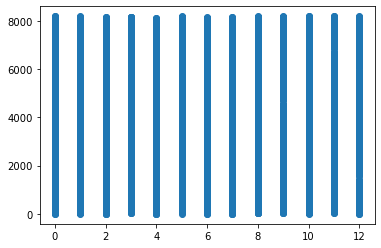

In [10]:
xpol = []
ypol = []
for key, value in policy.items():
    xpol += [value]
    ypol += [key]
plt.scatter(xpol,ypol)

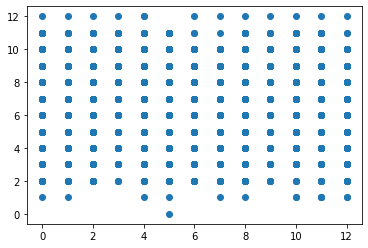

In [11]:
xpol = []
ypol = []
for key, value in policy.items():
    xpol += [value]
    ypol += ["{0:b}".format(key).count("1")]
plt.scatter(xpol,ypol)

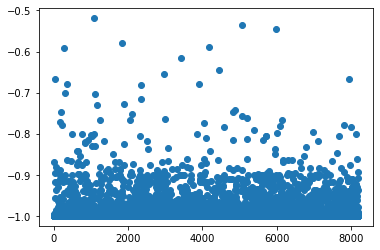

In [12]:
xQ = []
yQ = []
for key, value in Q.items():
    xQ += [key]
    yQ += [max(value)]
plt.scatter(xQ,yQ)

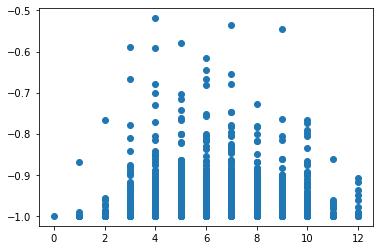

In [13]:
xQ = []
yQ = []
for key, value in Q.items():
    xQ += ["{0:b}".format(key).count("1")]
    yQ += [max(value)]
plt.scatter(xQ,yQ)

In [14]:
# example of step action log, reward for all steps are 0 except for the end, of which due to the loss is -1
g = game()
g.reset()
while not g.gameOver():
    g.step()
    g.debug()
    print("")

step count 1
aHand defaultdict(<class 'int'>, {1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 2, 10: 3, 11: 1, 12: 0, 13: 0})
cHand defaultdict(<class 'int'>, {1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 2, 12: 1, 13: 0})
deck remaining 37
book defaultdict(<class 'int'>, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0})
score [0, 0]

step count 2
aHand defaultdict(<class 'int'>, {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 2, 10: 3, 11: 1, 12: 0, 13: 0})
cHand defaultdict(<class 'int'>, {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 2, 12: 1, 13: 0})
deck remaining 36
book defaultdict(<class 'int'>, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0})
score [0, 0]

step count 3
aHand defaultdict(<class 'int'>, {1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 3, 11: 0, 12: 0, 13: 1})
cHand defaultdict(<class 'int'>, {1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0

In [41]:
def compress(list):
    c = []
    for i in range(0,len(list),10):
        c += [np.average(list[i:i+10])]
    return c

In [42]:
compress(score)

[2.8,
 2.7,
 3.3,
 3.3,
 2.7,
 2.9,
 2.7,
 2.5,
 1.9,
 3.1,
 2.8,
 3.1,
 2.9,
 3.4,
 2.8,
 2.5,
 2.3,
 3.1,
 2.8,
 2.7,
 1.7,
 4.1,
 3.5,
 3.6,
 2.7,
 2.4,
 2.3,
 3.3,
 2.8,
 2.4]

In [1]:
xscore = [i for i,j in scores[1::10]]
yscore = [j for i,j in scores]
plt.plot(xscore,compress(yscore))
#plt.xscale('log',basex=10)

NameError: name 'scores' is not defined

# Thus far

I have a working environment and reward system that is incentivizing behavior. At a base level, given pure random selection, the non-agent wins more often than not since the non-agent randomly selects card values that have not already been won. However, there is clearly something faulty, as I have only taught the agent to lose harder, desoute some learned and incentivized behavior that is apparent in the Q tables. It is difficult to teach, however, given the thousands of states, and the representation could be more effective. The x-axis represents the number of books won so far, but not what those books are, while the y axis shows the general behavior learned at those points. This is similarly true of the policy graph, as the last book to be won could be any value, so this representation needs improvement.

In [15]:
w = csv.writer(open("policyTD.csv", "w"))
for key, val in policy.items():
    w.writerow([key, val])

In [16]:
w = csv.writer(open("QTD.csv", "w"))
for key, val in Q.items():
    w.writerow([key, val])

In [17]:
w = csv.writer(open("scoreTD.csv", "w"))
for x in scores:
    w.writerow([x[0], x[1]])